# BEE 4750 Homework 3: Uncertain Sea-Level Rise and Levee Reliability

**Name**: Jonathan Marcuse

**ID**: jrm564

> **Due Date**
>
> Friday, 10/06/23, 9:00pm

## Overview

### Instructions

This assignment asks you to conduct a Monte Carlo analysis of levee
reliability in the face of uncertain changes to local sea levels. You
will propagate uncertainty in equilibrium climate sensitivity through
the energy balance model to obtain a distribution of temperatures, which
will then drive a model of sea-level rise. You will finally use this
distribution to assess the probability that a planned levee will achieve
its desired reliability standard.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/Cornell/Fall2023/BEE4750/hw3-jrmarcuse`


In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 40 Points)

### Problem 1 (12 points)

Recall from class that the simple energy balance model (EBM) of
planetary energy balance links changes in radiative forcing ($F$) to
global mean temperature ($T$) changes through the discretized equation
$$T_{i+1} = T_{i} + \frac{F_i - \lambda T_i}{cd} \times \Delta t,$$
where $i$ is the current time step, $c = 4.184 \times 10^6$
J/K/m<sup>2</sup> is the heat capacity of water per unit area, $d$ is
the (uncertain) depth of the mixing layer, $\Delta t$ is the annual time
step in seconds and $\lambda = F_{\text{2xCO}_2}/S$ is the climate
feedback parameter in W/m<sup>2</sup>/$^\circ$ C, where $S$ is the
equilibrium climate sensitivity (the uncertain equilibrium temperature
change resulting from a doubling of atmospheric CO<sub>2</sub>).
Finally, while total radiative forcing can be the result of non-aerosol
and aerosol effects, we do not know the relative intensity of aerosol
forcing, so we represent this with an uncertain aerosol scaling factor
$\alpha$.

We can implement this model with the following Julia function. We will
assume an ocean mixing depth $d = 100$ m and an aerosol scaling factor
$\alpha = 1.3$ so we can focus on the uncertainty in $S$.

The last technical concern is that “global mean temperature” does not
make sense in absolute terms as a marker of climate change. Instead, we
typically refer to temperature changes relative to some historical
pre-industrial baseline. In this case, we will use the period from
1880-1900, though this choice can vary.

In [3]:
# we need to split up the aerosol and non-aerosol forcings when we call the function
function energy_balance_model(S, forcing_aerosol, forcing_non_aerosol)
    d = 100 # ocean mixing depth [m]
    α = 1.3 # aerosol scaling factor
    F2xCO₂ = 4.0 # radiative forcing [W/m²] for a doubling of CO₂
    λ = F2xCO₂/S
    
    c = 4.184e6 # heat capacity/area [J/K/m²]
    C = c*d # heat capacity of mixed layer (per area)

    F = forcing_non_aerosol + α*forcing_aerosol # radiative forcing

    Δt = 31558152.0 # annual timestep [s]
    
    T = zero(F)
    for i in 1:length(F)-1
        T[i+1] = T[i] + (F[i] - λ*T[i])/C * Δt
    end
    # return temperature anomaly relative to 1880-1900 baseline
    return T .- mean(T[1:21]) 
end

energy_balance_model (generic function with 1 method)

Finally, we need to load some radiative forcing data. We will use the
radiative forcing scenario RCP 8.5. We can load this data, which is in a
`.csv` (comma-delimited) file, into a `DataFrame`, which is a tabular
data structure. Rows and columns in a `DataFrame` can be accessed using
their numerical index (like a matrix), but columns also have names; you
can access a particular column in a dataframe `df` by name using
`df.colname` or `df[:, "colname"]`.

Of note: this data set goes from 1750–2500, so you will need to take
care to make sure you are using the right years at each step. For
example, here we will constrain the data to 1880–2100, which is the
period we are interested in.

In [4]:
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all_85 = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# get the years corresponding to the forcings
t = Int64.(forcings_all_85[!,"year"]) # Ensure that years are interpreted as integers
# find the indices of the years 1880 and 2100
# we can do this with the indexin function
time_bounds = indexin([1880, 2100], t)
years = time_bounds[1]:time_bounds[2] # create range of years

# Separate out the individual components
forcing_co2_85 = forcings_all_85[years,"co2"]
# Get total aerosol and non-aerosol forcings
forcing_aerosol_rad_85 = forcings_all_85[years,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_85 = forcings_all_85[years,"aerosol-cloud_interactions"]
forcing_aerosol_85 = forcing_aerosol_rad_85 + forcing_aerosol_cloud_85 # aerosol forcings
forcing_total_85 = forcings_all_85[years,"total"] 
forcing_non_aerosol_85 = forcing_total_85 - forcing_aerosol_85 # non-aerosol forcings

221-element Vector{Float64}:
  0.42741479112315905
  0.4487940147601447
  0.4900144276528058
 -0.019811270078689047
 -1.480725700367619
 -0.3154905163510021
  0.233186559774844
  0.2923308952663089
  0.45833872365810924
  0.5168189581089915
  ⋮
  9.879065698371564
  9.946850640754889
 10.002169546141578
 10.061009359425011
 10.115684195707905
 10.182946497594184
 10.249699157847772
 10.331407709334023
 10.424544495740134

For this assignment, you can use the `forcing_aerosol_85` and
`forcing_non_aerosol_85` vectors as is to correspond to the relevant
forcings. You will need to use the vector `t` to find the appropriate
years for analysis.

#### Problem 1.1 (3 points)

Assume that $S$ is distributed according to
$\text{LogNormal}(\log(3.2), \log{2}/3)$ (as in class). Draw 10,000
samples from this distribution and make a histogram.

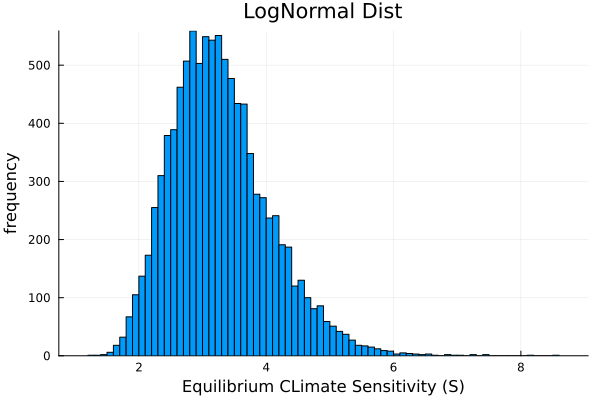

In [5]:
#define the logNormal Dist
S_Dist = LogNormal(log(3.2),log(2)/3);
#create a vector of 10,000 random samples
Random.seed!(1)
samples= rand(S_Dist,10000)

#plot the histogram using an appropriate bin value
    #of 50 to get frequency within smaller ranges
histogram(samples,xlabel="Equilibrium CLimate Sensitivity (S)",ylabel="frequency",
title="LogNormal Dist",legend=false)

#### Problem 1.2 (5 points)

Use the EBM to propagate your samples of $S$ to a distribution of global
mean temperature. Plot the median and 90% predictive distribution
(between the .05 and .95 quantiles) from 1880-2100.

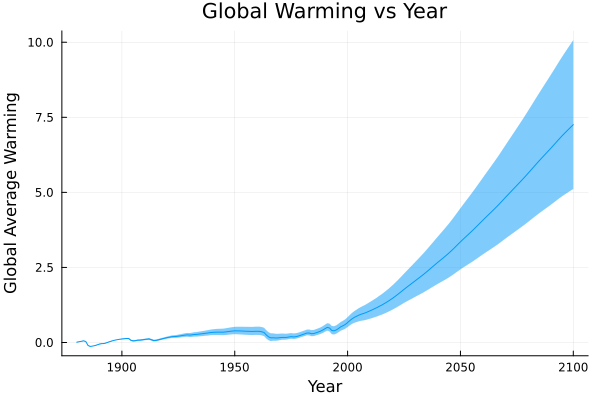

In [6]:
#define median, lower bound & upper bound confidence interval
median_S = median(samples);
LB_S = quantile(samples,0.05);
UB_S = quantile(samples,0.95);

#return Global Average Temperature based on LB, median and UB
LB_GAT = energy_balance_model(LB_S, forcing_aerosol_85, forcing_non_aerosol_85);
median_GAT = energy_balance_model(median_S, forcing_aerosol_85, forcing_non_aerosol_85);
UB_GAT = energy_balance_model(UB_S, forcing_aerosol_85, forcing_non_aerosol_85);

#create x-values as years
x_values = 1880:2100;

plot(x_values,median_GAT, ribbon =(median_GAT-LB_GAT, UB_GAT-median_GAT),legend=false,
xlabel="Year",ylabel="Global Average Warming",title="Global Warming vs Year")

#### Problem 1.3 (4 points)

Make a histogram of global mean temperature projections in 2100. If you
compare this distribution to the distribution of $S$ from Problem 1.1,
what do you observe?

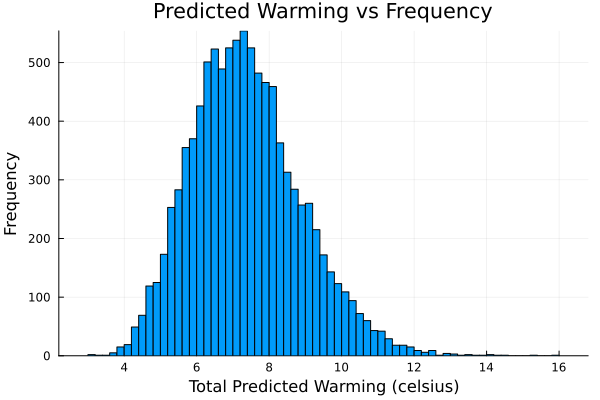

In [7]:
#The function below returns just the last value in the vector that 
    #energy_balance_model returns
function last_year_prediction(S,forcing_aerosol,forcing_non_aerosol)
    T = energy_balance_model(S,forcing_aerosol,forcing_non_aerosol);
    T = T[end];
    return T
end

#loop to get all of the 2100 model predictions for all values of samples
    #which was created from the LogNormal Distribution earlier
T_predictions= [last_year_prediction(samples[i], forcing_aerosol_85, 
forcing_non_aerosol_85) for i in 1:10000]

#histogram of frequency of values of temperature warming predictions  
    #in the year 2100 with the same bin# as problem 1.1 for comparison
histogram(T_predictions,xlabel="Total Predicted Warming (celsius)",ylabel="Frequency",
title="Predicted Warming vs Frequency",legend=false)

The distribution looks very similar to the plots of the S distribution in Problem 1.1. It has the same shape and centered peak, but different x_values as they are referencing different functions.

### Problem 2 (15 points)

Changes to global temperatures cause changes in global sea levels
through several mechanisms, including thermal expansion (the change in
ocean volume due to increased heat content) and melting land-based ice.
One simple way to represent this link is through the following model,
proposed by [Rahmstorf (2007)](https://doi.org/10.1126/science.1135456).

$$\frac{dH}{dt} = a(T-T_0),$$

where $H$ is the global mean sea level in mm, $T$ is global mean
temperature, $T_0$ is an equilibrium temperature (where there is no
change in sea levels), and $a$ is a proportionality constant. This model
can be discretized to give $$H_{i+1} - H_i = a (T_i - T_0).$$

Note that, like with global mean temperature, the notion of “global mean
sea level” does not make sense in absolute terms (were sea levels ever
at “zero”?). Instead, we want to normalize this relative to some
historical baseline. In this case (with a view towards Problem 3), we
will compute our sea levels relative to the 2010 sea level. Note that in
addition to the model parameters, we also need an initial sea-level
parameter $H_0$ which will give us the right anomaly level.

The best estimates for these parameters are:

-   $a = 1.86$;
-   $H_0 = -223$;
-   $T_0 = -0.62$

#### Problem 2.1 (5 points)

Write a function `sea_level_model()` to implement the mathematical
sea-level rise model described above. It should take in needed
parameters and a vector of temperatures and return a vector of sea
levels. To test your function, use the provided temperature series
`historical_temps` (read in below) to compute the global mean sea level
anomaly in 2022 (the last year of the dataset) with the parameter values
above; you should get a value of approximately 40mm.

In [8]:
historical_temp_data = CSV.read("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv", DataFrame, delim=",")
# column 2 is the temperature anomaly, column 1 is the year
temp_bds = indexin([1880, 1900], historical_temp_data[!, 1]) # find the index of 2010 for normalization
historical_temp_data[:, 2] .-= mean(historical_temp_data[temp_bds[1]:temp_bds[2], 2])
historical_temps = historical_temp_data[temp_bds[1]:end, 2]

143-element Vector{Float64}:
  0.07297116761904765
  0.15655772761904765
  0.09327316761904769
  0.04232884761904765
 -0.10351681238095234
 -0.08232033238095232
 -0.03210037238095231
 -0.10998251238095236
  0.00942435761904764
  0.13890768761904768
  ⋮
  1.0616748976190478
  1.2139176176190476
  1.3217303776190477
  1.2339774976190476
  1.1514572476190477
  1.2798758476190477
  1.3115970476190477
  1.1506591476190478
  1.1896871476190476

In [9]:
#function tocalculate sea level rise relative to 2010 levels in mm
    #temp_vec is a vector of all temperature data normalized, H_0 is the global mean sea level in mm, 
    #T is global mean temperature, T_0 is an equilibrium temperature, a is a proportionality constant,
    # and index_2010 is the index in the temp_vec that is the year 2010
function sea_level_model(temp_vec,a,H_0,T_0,index_2010)
    #initialize sea level vector 
    sea_lvl_vec = zeros(length(temp_vec));

    #add first term in vector so that the rest can be looped
    sea_lvl_vec[1]= a*(temp_vec[1]-T_0)+H_0;

    #write discretized sea level function
    for i = 2:length(temp_vec)
        sea_lvl_vec[i] = a*(temp_vec[i]-T_0)+sea_lvl_vec[i-1];
    end
    #renormalize to output in 2010
    norm = sea_lvl_vec[index_2010]
    sea_lvl_vec .-= norm
    return sea_lvl_vec
end

sea_level_model (generic function with 1 method)

In [10]:
sea_level_model(historical_temps,1.86,-223,-0.62,131)

143-element Vector{Float64}:
 -220.7077404024277
 -219.26334302905627
 -217.93665493728486
 -216.70472328071344
 -215.744064551742
 -214.7439803699706
 -213.65048706259915
 -212.70185453562772
 -211.5311252304563
 -210.11955693148488
    ⋮
   11.991354659085715
   15.402441427857141
   19.014059930228573
   22.4624580758
   25.75736855637143
   29.291137632942856
   32.88390814151428
   36.17733415608571
   39.54335225065714

The last value in the sea level vector is 39.54mm which is approximately 40mm

#### Problem 2.2 (5 points)

Evaluate `sea_level_model()` using the projected temperature ensemble
from Problem 1. Plot the 90% projection interval of the sea levels.

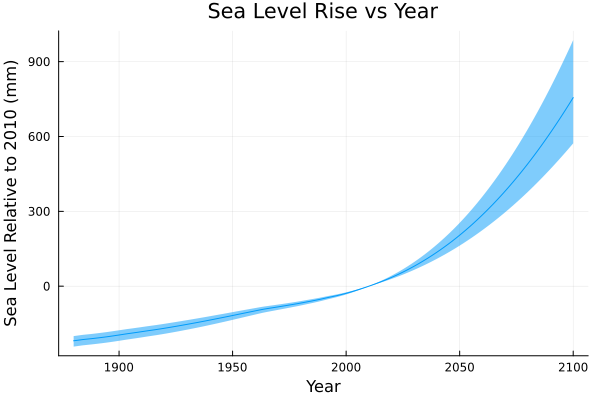

In [11]:
#Normalize temps based on the mean of 1880 to 1900
LB_Temps = LB_GAT .-= mean(LB_GAT[1:20]);
Median_Temps = median_GAT .-= mean(median_GAT[1:20]);
UB_Temps = UB_GAT .-= mean(UB_GAT[1:20]);

LB_Sea = sea_level_model(LB_Temps,1.86,-223,-0.62,131)
Median_Sea = sea_level_model(Median_Temps,1.86,-223,-0.62,131)
UB_Sea = sea_level_model(UB_Temps,1.86,-223,-0.62,131)

#x-value years will go from 1900 to 2100 now instead of 1880 to 2100
xvalues = 1880:2100

plot(xvalues,Median_Sea, ribbon =(Median_Sea-LB_Sea, UB_Sea-Median_Sea),legend=false,
xlabel="Year",ylabel="Sea Level Relative to 2010 (mm)",title="Sea Level Rise vs Year")

#### Problem 2.3 (5 points)

Make a histogram of the sea-level anomaly in 2100. What can you observe
about how the ECS uncertainty has impacted sea-level uncertainty under
this radiative forcing scenario? What might the implications be of only
using the best-estimate ECS value?

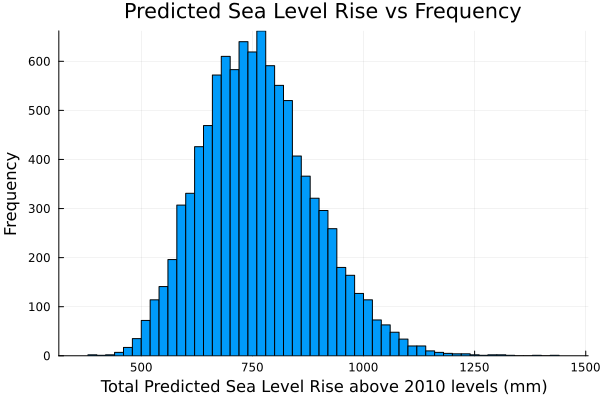

In [12]:
#The function below returns just the last value in the vector that 
    #sea_level_model returns
function last_year_sea(temp_vec,a,H_0,T_0,index_2010)
    S = sea_level_model(temp_vec,a,H_0,T_0,index_2010);
    S = S[end];
    return S
end

#making a 10,000 element vector with each element being a 221 element vector of temperatures
T = [energy_balance_model(samples[i], forcing_aerosol_85, forcing_non_aerosol_85) for i in 1:length(samples)]

#determining total sea level rise in 2100 based on every vector of temperatures within T
S_predictions = [last_year_sea(T[i],1.86,-223,-0.62,131) for i in 1:length(T)]

histogram(S_predictions,xlabel="Total Predicted Sea Level Rise above 2010 levels (mm)",ylabel="Frequency",
title="Predicted Sea Level Rise vs Frequency",legend=false)
    

***check this*** The uncertainty in ECS is magnified in the uncertainty of sea level rise. This is because the duration of the predictions are nearly a century into the future and the uncertainty curves widen with time in the model. 

### Problem 3 (13 points)

You’ve been asked to consult on a levee reliability analysis. For
context, levees in the United States are supposed to only fail once in
100 years, or, in other words, to have at most a 1% chance of failure in
a given year. We will assume for this problem that the only way in which
a levee fails is by being overtopped (note: this is unrealistic).

We can assess the probability of levee overtopping by comparing its
height to a distribution of extreme sea levels. A common approach is to
look at the distribution of the highest sea level each year. These
extreme sea levels can be obtained by combining the absolute sea level
(we will use our distribution of global sea levels for this), the rate
of subsidence (how much the ground sinks), and the distribution of storm
tides (the highest tide level, which is often the result of storm surges
combining with high tide).

Assume for this problem that:

1.  the annual rate of subsidence $\nu$ is 1.2mm/yr;
2.  the distribution of annual storm tide maxima, above the mean sea
    level, is (and is expected to continue to be) given by a
    $\text{GeneralizedExtremeValue}(900, 25, 0.3)$ distribution, which
    looks like this:

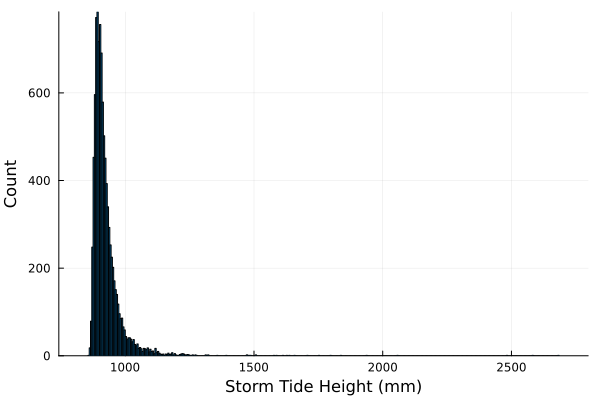

In [13]:
tide_distribution = GeneralizedExtremeValue(900, 25, 0.3)
    histogram(rand(tide_distribution, 10000), xlabel="Storm Tide Height (mm)", ylabel="Count", legend=:false)

Feel free to just sample from `tide_distribution` in your solution
below.

#### Problem 3.1 (2 points)

How would you use your sea-level simulations and the above information
to compute a distribution of extreme sea levels in 2100 relative to 2010
mean sea level? Write down the approach in clear steps, with equations
as needed.

Select a random height from the tide distribution.

Add the random value to one element in the predicted sea level rise in 2100 data vector.

Choose another random height from the tide distribution and add it to the next element in the sea level rise in 2100 vector.

Implement this in a for-loop so that every element of the sea level rise in 2100 vector has a randomly chosen storm tide height added to it.

Plot the extreme sea level rise values on a histogram.

#### Problem 3.2 (3 points)

Follow the steps above and produce a histogram of the extreme sea levels
in 2100 relative to 2010.

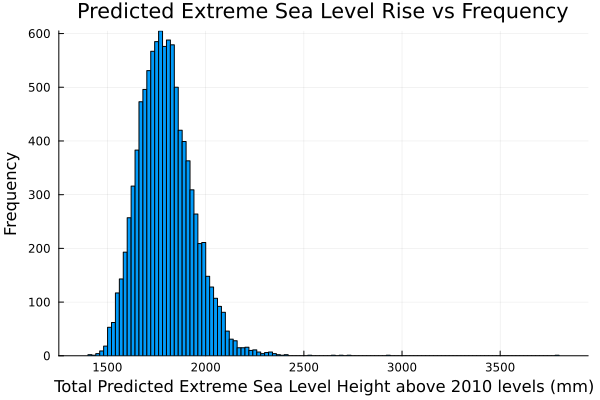

In [17]:
extreme_sea = [S_predictions[i]+rand(tide_distribution)+1.2*91 for i in 1:length(S_predictions)] #1.2mm of subsidence per year since 2010 would be 1.2*91 mm
histogram(extreme_sea,xlabel="Total Predicted Extreme Sea Level Height above 2010 levels (mm)",ylabel="Frequency",
title="Predicted Extreme Sea Level Rise vs Frequency",legend=false)

#### Problem 3.3 (5 points)

The current levee was heightened in 2010 to 2m above the 2010 mean sea level. Based on your analysis above, what is the probability that the levee will be overtopped in 2100 (remember that the reliability standard is 1%)?

In [18]:
#Total amount of extreme sea level predictions that are over 2000mm (2m)
    #divided by the total amount of extreme sea level predictions (length of extreme_sea)
p = count(x -> x>2000, extreme_sea)/length(extreme_sea)

0.0767

The probability is 7.67% which is greater than the reliability standard of 1%, so the levee does not meet the requirement with the modeled sea level rise.

#### Problem 3.4 (3 points)

Based on your analysis, would you recommend that the levee be heightened
again in the future, and if so, how high? What other information might
you need, if any, to make your recommendation?

In [19]:
#initialize probability and wall height parameters
p=1;
i=2000;

#while loop to increase wall height until probability of levee failure is less than or equal to 1%
while p>0.01
    i = i+1
    p = count(x -> x>i, extreme_sea)/length(extreme_sea)
end

return i

2166

Based on my analysis, the levee will have to be heightened in the future and in order to reach the 1% reliability standard based on the current data, it will have to be increased an additional 166mm. However, global temperature data and sea level rise data should be updated and rerun in the model to achieve more reliable estimates. It is possible the distribution used in this example could be an underestimation of the true global warming we will see in the future and as new data is released it should be added to the model.

## References

List any external references consulted, including classmates.